In [ ]:
## credits:- https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8
## credits to: - Harshall Lamba

## Importing Necessary Libraries

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os
import string
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


## Loading the Text Document

In [10]:
## writing a fnction for loading the document in the memory.

def documentLoader(file):
    ## open the file
    file = open(file,'r')
    ## read text
    text = file.read()
    ## close the file
    file.close()
    return text


file = "D:\Datasets\Flicker8\captions.txt"
document = documentLoader(file)
print(document[:560])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with eac


## Preprocessing the Documents

In [13]:
def descriptionLoader(document):
    ## Creating an empty dictionary where name of the image will be keys and a list of 5 captions as values
    mapping = dict()
    ## process line by line
    for line in doc.split('\n'):
        ## now split lie by white line
        tokens = line.split()
        if len(line) < 2:
            continue
        ## take the first token as image_id and rest as description
        image_id, image_desc = tokens[0], tokens[1:]
        ## extract filename from image_id
        image_id = image_id.split('.')[0]
        ## converting description tokens back to string
        image_desc = ' '.join(image_desc)
        ## creating list
        if image_id not in mapping:
            mapping[image_id] = list()
        ## store descriptions
        mapping[image_id].append(image_desc)
    return mapping

descriptions = descriptionLoader(document)
print(len(descriptions))

8092


In [19]:
list(descriptions.keys())[1:6]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [20]:
descriptions['1000268201_693b08cb0e']

['child in a pink dress is climbing up a set of stairs in an entry way .',
 'girl going into a wooden building .',
 'little girl climbing into a wooden playhouse .',
 'little girl climbing the stairs to her playhouse .',
 'little girl in a pink dress going into a wooden cabin .']

In [21]:
descriptions['1001773457_577c3a7d70']

['black dog and a spotted dog are fighting',
 'black dog and a tri-colored dog playing with each other on the road .',
 'black dog and a white dog with brown spots are staring at each other in the street .',
 'dogs of different breeds looking at each other on the road .',
 'dogs on pavement moving toward each other .']

In [34]:
## Now we have to clean the descriptions that we have just process.
def clean_descriptions(descriptions):
    ## prepare a translation table for removing the punctuations
    table =str.maketrans('','', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            ## tokenize
            desc = desc.split()
            ## convert to lower
            desc = [word.lower() for word in desc]
            ## remove punctuations from each token
            desc = [word.translate(table) for word in desc]
            ## removing hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            ## removing alpha numeric tokens
            desc = [word for word in desc if word.isalpha()]
            ## again storing as a string
            desc_list[i] = ' '.join(desc)

clean_descriptions(descriptions)

In [35]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [36]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'dogs of different breeds looking at each other on the road',
 'dogs on pavement moving toward each other']

## Creating a Vocabulary of the Loaded Descriptions

In [42]:
## We are creating this vocabulary to find the unique words from 8000 images having 5 captions each. 8000*5 = 40000
def vocabulary(descriptions):
    ## building a list of all description strings
    all_desc = set()
    
    for key in descriptions.keys():
        for d in descriptions[key]:
            all_desc.update(d.split())
    return all_desc

vocab = vocabulary(descriptions)
print(len(vocab))

8680


## Saving Descriptions in a .txt file

In [44]:
## Saving the description along with their image names in a new file called descriptions.txt
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')

## Creating the names of Images from the training data and testing data

In [62]:
import os
names = []
files = os.listdir("""D:\Datasets\Flicker8\Train Images""")
for file in files:
    #print(file)
    names.append(file)

print(len(names))

6000


In [74]:
names = []
files = os.listdir("""D:\Datasets\Flicker8\Test Images""")
for file in files:
    #print(file)
    names.append(file)

print(len(names))

1091


## Saving those image names in a .txt format

In [64]:
lines = list()
for name in names:
    lines.append(name)
    data = '\n'.join(lines)
    file = open('Flickr_8k.trainingImages.txt', 'w')
    file.write(data)
    file.close()

In [75]:
lines = list()
for name in names:
    lines.append(name)
    data = '\n'.join(lines)
    file = open('Flickr_8k.testingImages.txt', 'w')
    file.write(data)
    file.close()

## Loading that names .txt file in a 'train' variable

In [72]:
## loading the image names for the trining set
def load_set(filename):
    doc = open(filename, 'r')
    doc = doc.read()
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
filename = 'Flickr_8k.trainingImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


## Processing of the actual train images descriptions

In [98]:
## Path to all the images
images = "D:/Datasets/Flicker8/Images/"
## creating list of all the images in the directory; img cntains full path of the image along with its name
img = glob(images + "*.jpg")

In [100]:
# Below file conatains the names of images to be used in train data
train_images_file = 'Flickr_8k.trainingImages.txt'
## reading the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [103]:
## cerate an empty list of all training images with their full path names
train_img = []

## below contains list of full path names of all images
for i in img:
    ## checking if the images belongs to the trainings set
    if i[len(images):] in train_images:
        train_img.append(i)

In [106]:
## same steps for test images

# Below file conatains the names of images to be used in test data
test_images_file = 'Flickr_8k.testingImages.txt'
## reading the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

## cerate an empty list of all testing images with their full path names
test_img = []

## below contains list of full path names of all images
for i in img:
    ## checking if the images belongs to the testing set
    if i[len(images):] in test_images:
        test_img.append(i)

In [109]:
## Load cleaned descriptions into memory
def load_clean_descriptions(filename, dataset):
    ## document loading
    doc = open(filename,'r').read()
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq' + ' '.join(image_desc) + 'endseq'
            descriptions[image_id].append(desc)
    return descriptions

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print(len(train_descriptions))

6000


In [110]:
def preprocess(image_path):
    # Convert all the images to size 299x299 (required for inception model)
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [113]:
## Loading inception Model
model = InceptionV3(weights = 'imagenet')

W0325 03:22:45.846760 14184 deprecation_wrapper.py:119] From C:\Users\PIYUSH\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0325 03:22:46.492736 14184 deprecation_wrapper.py:119] From C:\Users\PIYUSH\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0325 03:22:46.649118 14184 deprecation_wrapper.py:119] From C:\Users\PIYUSH\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0325 03:22:46.901979 14184 deprecation_wrapper.py:119] From C:\Users\PIYUSH\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0325 03:22:46.902942 14184 deprecation_wrapper.py:1

96116736/96112376 [==============================] - 118s 1us/step


In [115]:
## Removing the output or last layer of the pretrained model
model_new = Model(model.input, model.layers[-2].output)

In [120]:
## Function to convert an image to a vector of size (2048, )
def encode(image):
    image = preprocess(image)
    ## Get the vector 
    fea_vec = model_new.predict(image)
    ## reshape the vector from(1, 2048) to (2048, )
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [121]:
## Function call to encode all train images
start = time.time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
end = time.time()

print("Time taken: ", str(end-start))

Time taken:  2076.887130498886


In [128]:
import pickle
from pickle import load, dump

In [129]:
## Saving the bottleneck train features to disk
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [130]:
start = time.time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
end = time.time()

print("Time taken: ", str(end-start))

Time taken:  410.50648260116577


In [132]:
with open("encoded_test_images.pkl", 'wb') as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [133]:
train_features = load(open('encoded_train_images.pkl','rb'))
print(len(train_features))

6000


In [134]:
## creating a list of all training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
print(len(all_train_captions))

30000


In [136]:
## Consider the word which occurs at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents = nsents + 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
        
vocab1 = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed_words: ', len(word_counts), len(vocab1))

preprocessed_words:  10737 1956


In [137]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab1:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix +=1

In [138]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1957

In [141]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 31


In [175]:
## Data Generator
def data_generator(descriptions, photos, wordtoix, max_length, number_of_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n = 0
    ## Loop over every image
    while 1:
        for key, desc_list in descriptions.items():
            n = n+1
            ## retrive the photo features
            photo = photos[key+ '.jpg']
            for desc in desc_list:
                ## encoding the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                ## split 1 seq int multiple X, y pairs
                for i in range(1, len(seq)):
                    ## split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    ## pad input
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    ## encode output sequence
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    ## storing
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            ## yeild batch data
            if n==number_of_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n = 0

In [176]:
## Loading the glove vectors
glove_dir = 'D:\Datasets\Flicker8\glove.6B.200d.txt'
embeddings_index = {} ## empty directory
f = open(os.path.join(glove_dir, 'D:\Datasets\Flicker8\glove.6B.200d.txt'), encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print(len(embeddings_index))

400000


In [177]:
embedding_dim = 200
## get a 200 dimension vector for each of 10000 words in the vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        ## words not found in the embedding mtrix will be zeros
        embedding_matrix[i] = embedding_vector

In [178]:
embedding_matrix.shape

(1957, 200)

In [179]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [180]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 31)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 31, 200)      391400      input_9[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2048)         0           input_8[0][0]                    
__________________________________________________________________________________________________
dropout_8 

In [181]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [182]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [183]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [186]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 908s 454ms/step - loss: 3.6927
Epoch 1/1
2000/2000 [==============================] - 901s 450ms/step - loss: 3.5345
Epoch 1/1
2000/2000 [==============================] - 899s 450ms/step - loss: 3.4206
Epoch 1/1
2000/2000 [==============================] - 903s 452ms/step - loss: 3.3317
Epoch 1/1
2000/2000 [==============================] - 909s 455ms/step - loss: 3.2608
Epoch 1/1
2000/2000 [==============================] - 912s 456ms/step - loss: 3.2031
Epoch 1/1
2000/2000 [==============================] - 911s 455ms/step - loss: 3.1534
Epoch 1/1
2000/2000 [==============================] - 911s 455ms/step - loss: 3.1121
Epoch 1/1
2000/2000 [==============================] - 920s 460ms/step - loss: 3.0731
Epoch 1/1
2000/2000 [==============================] - 912s 456ms/step - loss: 3.0402


In [187]:
model.save_weights('model_10.h5')

In [189]:
model.load_weights('model_10.h5')

In [190]:
with open('encoded_test_images.pkl', 'rb') as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [202]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen = max_length)
        y_hat = model.predict([photo, sequence], verbose=0)
        y_hat = np.argmax(y_hat)
        word = ixtoword[y_hat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

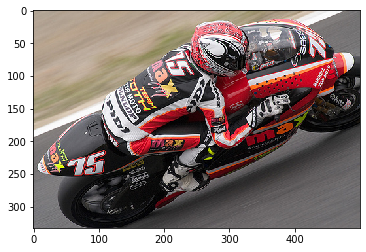

Greedy:  racer is riding white motorcycleendseq that is on the roadendseq of the roadendseq roadendseq it is driving through the mudendseq pipeendseq that has fallen on the roadendseq of the roadendseq


In [216]:
z=0
z+=28
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1, 2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print('Greedy: ', greedySearch(image))